In [1]:
import torch
from tqdm import tqdm
from dataset import get_dataloaders
from model import BiLSTM_CRF
import matplotlib.pyplot as plt
from bio_to_entities import bio_to_entities

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем {device}")

Используем cuda


In [ ]:
def extract_entities(tag_ids, idx2tag):
    """
    Извлекает сущности из последовательности меток.
    Возвращает список кортежей: [(label, start, end), ...]
    """
    entities = []
    i = 0
    while i < len(tag_ids):
        tag = idx2tag[tag_ids[i]]
        if tag.startswith("B-"):
            label = tag[2:]
            start = i
            i += 1
            # Собираем все I-теги того же класса
            while i < len(tag_ids) and idx2tag[tag_ids[i]] == f"I-{label}":
                i += 1
            end = i
            entities.append((label, start, end))
        else:
            i += 1
    return entities

def compute_entity_f1(true_sequences, pred_sequences, idx2tag):
    """
    Вычисляет entity-level F1 по правилам SROIE:
    - Точное совпадение типа, начала и конца сущности.
    """
    tp = fp = fn = 0

    for true_seq, pred_seq in zip(true_sequences, pred_sequences):
        # Обрезаем до минимальной длины (защита от ошибок)
        min_len = min(len(true_seq), len(pred_seq))
        true_seq = true_seq[:min_len]
        pred_seq = pred_seq[:min_len]

        true_entities = set(extract_entities(true_seq, idx2tag))
        pred_entities = set(extract_entities(pred_seq, idx2tag))

        tp += len(true_entities & pred_entities)
        fp += len(pred_entities - true_entities)
        fn += len(true_entities - pred_entities)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    idx2tag,
    device,
    num_epochs=5,
    save_path="best_model.pth"
):
    best_val_f1 = 0.0
    train_losses = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        # ===== Обучение =====
        model.train()
        epoch_loss = 0.0
        for words, tags, lengths in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"
        ):
            words = words.to(device)
            tags = tags.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad()
            loss = model(words, tags, lengths.cpu())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        scheduler.step()

        # ===== Валидация с entity-level F1 =====
        model.eval()
        all_true_seqs = []   # списки истинных последовательностей меток
        all_pred_seqs = []   # списки предсказанных последовательностей
        val_epoch_loss = 0.0

        with torch.no_grad():
            for words, tags, lengths in val_loader:
                words = words.to(device)
                tags = tags.to(device)
                lengths_cpu = lengths.cpu()

                # Loss
                loss = model(words, tags, lengths_cpu)
                val_epoch_loss += loss.item()

                # Получаем предсказания
                predictions = model.predict(words,lengths_cpu)
                
                # Сохраняем без padding
                for i in range(len(lengths_cpu)):
                    length = lengths_cpu[i].item()
                    true_seq = tags[i][:length].cpu().numpy().tolist()
                    pred_seq = predictions[i][:length]
                    all_true_seqs.append(true_seq)
                    all_pred_seqs.append(pred_seq)

        avg_val_loss = val_epoch_loss / len(val_loader)
        epoch_f1 = compute_entity_f1(all_true_seqs, all_pred_seqs, idx2tag)
        val_f1_scores.append(epoch_f1)

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Entity F1: {epoch_f1:.4f}")

        # Сохраняем лучшую модель по F1
        if epoch_f1 > best_val_f1:
            best_val_f1 = epoch_f1
            torch.save(model.state_dict(), save_path)
            print(f"Новая лучшая модель сохранена (Entity F1: {epoch_f1:.4f})")

    return train_losses, val_f1_scores

In [3]:
# Загрузка данных
train_loader, val_loader, test_loader, word2idx, tag2idx, idx2tag = get_dataloaders(
    "train.json", "val.json", "test.json", batch_size=32, min_freq=1)

In [ ]:
torch.save({
        'model_state_dict': model.state_dict(),
        'word2idx': word2idx,
        'tag2idx': tag2idx,
        'idx2tag': idx2tag,
        'config': {
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'num_layers': num_layers
        }
    }, save_path)

In [4]:
model = BiLSTM_CRF(len(word2idx), tag2idx, embedding_dim=128, hidden_dim=1024, num_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

In [ ]:
train_losses, val_f1s = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    idx2tag=idx2tag,
    device=device,
    num_epochs=30,
    save_path="best_bilstm_crf.pt"
)

Epoch 1/30: 100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


Train Loss: 29.6433 | Val Loss: 15.1258 | Val Entity F1: 0.0167
Новая лучшая модель сохранена (Entity F1: 0.0167)


Epoch 2/30: 100%|██████████| 18/18 [00:08<00:00,  2.09it/s]


Train Loss: 14.7988 | Val Loss: 12.6502 | Val Entity F1: 0.3772
Новая лучшая модель сохранена (Entity F1: 0.3772)


Epoch 3/30: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


Train Loss: 13.3205 | Val Loss: 11.6212 | Val Entity F1: 0.3786
Новая лучшая модель сохранена (Entity F1: 0.3786)


Epoch 4/30: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


Train Loss: 12.2657 | Val Loss: 10.7775 | Val Entity F1: 0.3564


Epoch 5/30: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


Train Loss: 10.8895 | Val Loss: 9.9128 | Val Entity F1: 0.4407
Новая лучшая модель сохранена (Entity F1: 0.4407)


Epoch 6/30: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


Train Loss: 9.6222 | Val Loss: 10.6347 | Val Entity F1: 0.4542
Новая лучшая модель сохранена (Entity F1: 0.4542)


Epoch 7/30: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


Train Loss: 8.2898 | Val Loss: 9.2588 | Val Entity F1: 0.5397
Новая лучшая модель сохранена (Entity F1: 0.5397)


Epoch 8/30: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


Train Loss: 6.9000 | Val Loss: 8.6189 | Val Entity F1: 0.5350


Epoch 9/30: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


Train Loss: 5.6541 | Val Loss: 8.5552 | Val Entity F1: 0.5852
Новая лучшая модель сохранена (Entity F1: 0.5852)


Epoch 10/30: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


Train Loss: 4.5325 | Val Loss: 9.1299 | Val Entity F1: 0.5521


Epoch 11/30: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Train Loss: 3.5696 | Val Loss: 8.4131 | Val Entity F1: 0.6021
Новая лучшая модель сохранена (Entity F1: 0.6021)


Epoch 12/30: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Train Loss: 2.6776 | Val Loss: 8.9064 | Val Entity F1: 0.6174
Новая лучшая модель сохранена (Entity F1: 0.6174)


Epoch 13/30: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Train Loss: 1.9923 | Val Loss: 9.2332 | Val Entity F1: 0.6290
Новая лучшая модель сохранена (Entity F1: 0.6290)


Epoch 14/30: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Train Loss: 1.4493 | Val Loss: 10.1069 | Val Entity F1: 0.6544
Новая лучшая модель сохранена (Entity F1: 0.6544)


Epoch 15/30: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Train Loss: 1.0399 | Val Loss: 9.7923 | Val Entity F1: 0.6649
Новая лучшая модель сохранена (Entity F1: 0.6649)


Epoch 16/30: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Train Loss: 0.8178 | Val Loss: 10.1726 | Val Entity F1: 0.6520


Epoch 17/30: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


Train Loss: 0.7489 | Val Loss: 9.6565 | Val Entity F1: 0.6768
Новая лучшая модель сохранена (Entity F1: 0.6768)


Epoch 18/30: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Train Loss: 0.6354 | Val Loss: 9.6079 | Val Entity F1: 0.6818
Новая лучшая модель сохранена (Entity F1: 0.6818)


Epoch 19/30: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Train Loss: 0.5799 | Val Loss: 11.2838 | Val Entity F1: 0.6473


Epoch 20/30: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Train Loss: 0.6554 | Val Loss: 11.3849 | Val Entity F1: 0.6718


Epoch 21/30: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


Train Loss: 0.6512 | Val Loss: 10.0793 | Val Entity F1: 0.6667


Epoch 22/30: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


Train Loss: 0.4002 | Val Loss: 10.4776 | Val Entity F1: 0.6600


Epoch 23/30: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


Train Loss: 0.3961 | Val Loss: 10.9380 | Val Entity F1: 0.6768


Epoch 24/30: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


Train Loss: 0.2825 | Val Loss: 11.6314 | Val Entity F1: 0.6581


Epoch 25/30: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Train Loss: 0.2976 | Val Loss: 11.9092 | Val Entity F1: 0.6684


Epoch 26/30: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


Train Loss: 0.2071 | Val Loss: 12.1088 | Val Entity F1: 0.6809


Epoch 27/30: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


Train Loss: 0.1685 | Val Loss: 12.2797 | Val Entity F1: 0.6838
Новая лучшая модель сохранена (Entity F1: 0.6838)


Epoch 28/30: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Train Loss: 0.1234 | Val Loss: 12.4966 | Val Entity F1: 0.6791


Epoch 29/30: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


Train Loss: 0.1323 | Val Loss: 12.8440 | Val Entity F1: 0.6873
Новая лучшая модель сохранена (Entity F1: 0.6873)


Epoch 30/30: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


Train Loss: 0.1491 | Val Loss: 13.9261 | Val Entity F1: 0.6702


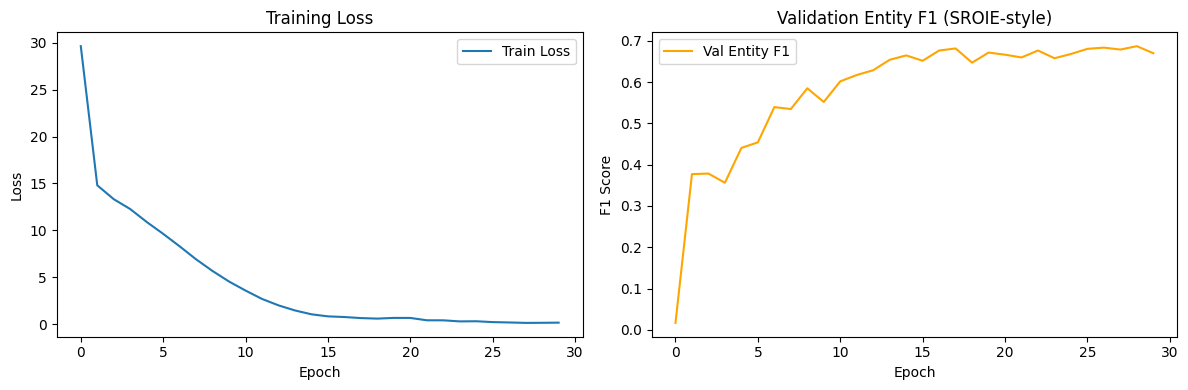

In [67]:
plt.figure(figsize=(12, 4))

# График loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# График F1
plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Val Entity F1", color="orange")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation Entity F1 (SROIE-style)")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
def predict_sample(model, words, word2idx, idx2tag, device):
    model.eval()
    with torch.no_grad():
        # Преобразуем слова в индексы
        word_ids = [word2idx.get(w, word2idx["<UNK>"]) for w in words]
        words_tensor = torch.tensor(word_ids, dtype=torch.long).unsqueeze(0).to(device)
        lengths = torch.tensor([len(words)], dtype=torch.long)  

        pred_ids = model.predict(words_tensor, lengths)[0]
        pred_tags = [idx2tag[idx] for idx in pred_ids]
    return pred_tags

In [12]:
model.load_state_dict(torch.load("best_model.pt", map_location=device))

<ipython-input-12-da826d326f89>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location=device))


<All keys matched successfully>

In [7]:
sample = test_loader.dataset.data[2]
words = sample["tokens"]
true_tags = sample["ner_tags"]

pred_tags = predict_sample(model, words, word2idx, idx2tag, device)

print("Токен\t\tИстина\t\tПредсказание")
print("-" * 60)
for w, true_t, pred_t in zip(words, true_tags, pred_tags):    
    print(f"{w:<40}\t{true_t:<12}\t{pred_t:<12}")

Токен		Истина		Предсказание
------------------------------------------------------------
PERNIAGAAN ZHENG HUI                    	B-company   	B-company   
JM0326955-V                             	O           	O           
NO.59 JALAN PERMAS 9/5                  	B-address   	B-address   
BANDAR BARU PERMAS JAYA                 	I-address   	I-address   
81750 JOHOR BAHRU                       	I-address   	O           
TEL:07-386 7524 FAX:07-386 3793         	O           	O           
GST NO: 000800689824                    	O           	O           
SIMPLIFIED TAX INVOICE                  	O           	O           
GOGIANT ENGINEERING (M) SDN BHD         	O           	O           
RECEIPT#: CS00082258                    	O           	O           
SALESPERSON:                            	O           	O           
DATE:09/02/2018                         	B-date      	O           
CASHIER: USER                           	O           	O           
TIME:08:32:00                           

In [8]:
bio_to_entities(words, pred_tags)

{'company': 'PERNIAGAAN ZHENG HUI',
 'date': '',
 'address': 'NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA',
 'total': ''}

In [ ]:
torch.save({
        'model_state_dict': torch.load("best_model.pt", map_location=device),
        'word2idx': word2idx,
        'tag2idx': tag2idx,
        'idx2tag': idx2tag,
        'config': {
            'embedding_dim': 128,
            'hidden_dim': 1024,
            'num_layers': 4
        }
    }, "best_model.pth")